In [1]:
import sys
import os

# Compute absolute path to the src/ folder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")

# Add src/ to sys.path
sys.path.insert(0, src_path)

# Now you can import the code
from qvarnet.hamiltonians import GeneralHamiltonian, HarmonicOscillator
from qvarnet.models.mlp import MLP
from qvarnet.samplersv2 import MetropolisHastingsSampler


import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.linalg import vector_norm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
class SimpleModel(nn.Module):
    def __init__(self, layer_dims=[1,30,1]):
        super(SimpleModel, self).__init__()
        self.mlp = MLP(layer_dims=layer_dims)

    def forward(self, x):
        psi = self.mlp(x)
        # [n_batches, dimension], then dim=-1 means take the norm of the dimensions, i.e. it would be a vector of 
        # shape [n_batches, 1] if the input is a single dimension, where each element is the norm of the corresponding vector in the batch.
        norm = vector_norm(psi, keepdim=True)
        # Normalize the wavefunction
        psi = psi / norm
        return psi

In [3]:
# model = MLP(layer_dims=[1,80,80,80, 100,1])
model = SimpleModel(layer_dims=[1, 2, 1])
model.to(device)
# for param in model.parameters():
#     if param.dim() > 1:
#         nn.init.xavier_uniform_(param)
#     else:
#         nn.init.zeros_(param)
print(model)
x = torch.linspace(-5, 5, 1000).view(-1, 1).to(device)
# Get the wavefunction
psi = model(x)
# Get the norm
norm = vector_norm(psi, keepdim=True)
print(f"Norm of the wavefunction: {norm.item()}")

for param in model.parameters():
    for i in param:
        print(i, end=", ")

SimpleModel(
  (mlp): MLP(input_dim=1, output_dim=1, hidden_dims=[2], activation=tanh)
)
Norm of the wavefunction: 1.0
tensor([-0.3087], device='cuda:0', grad_fn=<UnbindBackward0>), tensor([0.0936], device='cuda:0', grad_fn=<UnbindBackward0>), tensor(-0.4626, device='cuda:0', grad_fn=<UnbindBackward0>), tensor(-0.4613, device='cuda:0', grad_fn=<UnbindBackward0>), tensor([-0.6430,  0.4261], device='cuda:0', grad_fn=<UnbindBackward0>), tensor(0.3352, device='cuda:0', grad_fn=<UnbindBackward0>), 

In [4]:
import copy

class EarlyStoppingCallback:
    def __init__(self, patience=10, min_delta=1e-5):
        self.patience = patience
        self.min_delta = min_delta
        self.best_energy = None
        self.best_model_state = None
        self.epochs_without_improvement = 0
        self.stop_training = False

    def __call__(self, epoch, energy, model):
        # Initialize the best energy if it's the first epoch
        if self.best_energy is None:
            self.best_energy = energy
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.epochs_without_improvement = 0
        else:
            # Check if the energy has improved by more than min_delta
            if energy < (self.best_energy - self.min_delta):
                self.best_energy = energy
                self.best_model_state = copy.deepcopy(model.state_dict())
                self.epochs_without_improvement = 0
            else:
                self.epochs_without_improvement += 1

        # If there is no improvement for the specified patience, stop training
        if self.epochs_without_improvement >= self.patience:
            print(f"Stopping training after {epoch+1} epochs due to no improvement in energy.")
            self.stop_training = True

- `n_samples`: Number of points generated
# TEST

Number of samples: 4998
Sample mean: -0.0319
Sample std: 1.0136


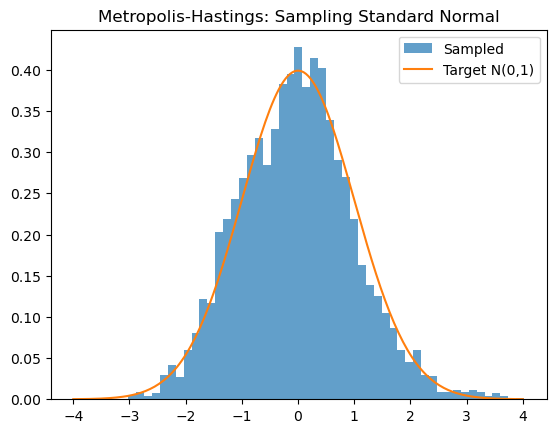

In [5]:
# Simple harmonic oscillator: E(x) = 0.5 * x^2
class HarmonicHamiltonian(GeneralHamiltonian):
    def forward(self, x):
        return 0.5 * x.pow(2).sum(dim=-1)

# Your sampler
sampler = MetropolisHastingsSampler(
    model=HarmonicHamiltonian(),
    n_samples=5000,
    step_size=0.5,
    burn_in=500,
    is_wf=False,
)

sampler.to(device)

# Initial point
x0 = torch.tensor([0.0], device=device)

# Run sampler
samples = sampler(x0, method="parallel", n_walkers=51)
samples_np = samples.cpu().detach().numpy().flatten()
print(f"Number of samples: {len(samples_np)}")

# Statistics
mean = samples_np.mean()
std = samples_np.std()

print(f"Sample mean: {mean:.4f}")
print(f"Sample std: {std:.4f}")

# Histogram
plt.hist(samples_np, bins=50, density=True, alpha=0.7, label='Sampled')
xs = torch.linspace(-4, 4, 200)
plt.plot(xs, torch.exp(-0.5 * xs**2) / (2 * torch.pi)**0.5, label='Target N(0,1)')
plt.legend()
plt.title("Metropolis-Hastings: Sampling Standard Normal")
plt.show()

# Computation

[[-2.64901165e-02]
 [-2.64397748e-02]
 [-2.63892263e-02]
 [-2.63384581e-02]
 [-2.62874849e-02]
 [-2.62362920e-02]
 [-2.61848923e-02]
 [-2.61332747e-02]
 [-2.60814372e-02]
 [-2.60293912e-02]
 [-2.59771291e-02]
 [-2.59246416e-02]
 [-2.58719437e-02]
 [-2.58190203e-02]
 [-2.57658791e-02]
 [-2.57125217e-02]
 [-2.56589428e-02]
 [-2.56051403e-02]
 [-2.55511161e-02]
 [-2.54968721e-02]
 [-2.54424065e-02]
 [-2.53877062e-02]
 [-2.53327936e-02]
 [-2.52776463e-02]
 [-2.52222773e-02]
 [-2.51666829e-02]
 [-2.51108557e-02]
 [-2.50548031e-02]
 [-2.49985252e-02]
 [-2.49420144e-02]
 [-2.48852745e-02]
 [-2.48283055e-02]
 [-2.47711036e-02]
 [-2.47136690e-02]
 [-2.46560052e-02]
 [-2.45981012e-02]
 [-2.45399717e-02]
 [-2.44816039e-02]
 [-2.44230013e-02]
 [-2.43641641e-02]
 [-2.43050903e-02]
 [-2.42457762e-02]
 [-2.41862293e-02]
 [-2.41264384e-02]
 [-2.40664165e-02]
 [-2.40061507e-02]
 [-2.39456389e-02]
 [-2.38848999e-02]
 [-2.38239132e-02]
 [-2.37626806e-02]
 [-2.37012077e-02]
 [-2.36394927e-02]
 [-2.3577539

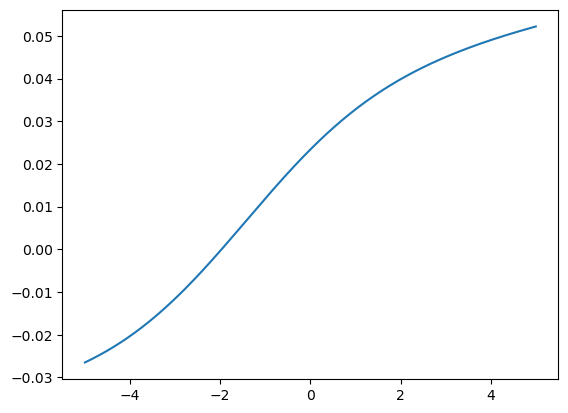

In [6]:
x = torch.linspace(-5, 5, 1000).view(-1, 1).to(device)
psi = model(x)
# Plot the wavefunction
plt.plot(x.cpu().numpy(), psi.cpu().detach().numpy(), label='Wavefunction')
print(psi.cpu().detach().numpy())

In [7]:
from tqdm import tqdm
epochs = 10000
model = SimpleModel(layer_dims=[1, 30, 1])
model.to(device)
# model = MLP(layer_dims=[1, 60, 1])
# model.to(device)

hamiltonian = HarmonicOscillator(model=model)
hamiltonian.to(device)

wf_history = []
samples_history = []

n_samples = 500

sampler = MetropolisHastingsSampler(
    model=model,
    n_samples=n_samples,
    step_size=0.5,
    burn_in=100,
    is_wf=True,
)
sampler.to(device)

callback = EarlyStoppingCallback(patience=1000, min_delta=1e-5)

optimizer = torch.optim.Adam(model.parameters(), lr=1e12)

print("model parameters:")
for name, param in model.named_parameters():
    print(name, param.shape)

# x_train = torch.linspace(-1, 1, 1000).view(-1, 1).to(device)
# x_train.requires_grad = True

# samples = torch.randn(10000, 1).to(device)
# samples.requires_grad = True

for epoch in (range(epochs)):
    optimizer.zero_grad()
    # Run sampler
    sampler.model = model
    x0 = torch.randn(1, device=device)
    samples = sampler(x0, method="parallel", n_walkers=(n_samples//2))
    # samples.requires_grad = True
    
    # Compute the mean and std of the local energy
    hamiltonian.model = model
    local_energy = hamiltonian(samples)
    psi = model(samples)
    energy = local_energy.mean().item()
    energy_std = local_energy.std().item()
    loss = local_energy.mean()

    callback(epoch, energy, model)
    if callback.stop_training:
        print("Early stopping triggered.")
        break
    
    if True and epoch % 100 == 0:
        wf_history.append(model.state_dict())
        samples_history.append(samples)
        

    # mask = torch.abs(samples.squeeze()) > 3  # shape: (batch_size,)
    
    # loss += 1e2 * (psi[mask]**2).sum()

    # boundary conditions
    # loss += 1e4 * (psi[0]**2+ psi[-1]**2).sum()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Energy: {energy:.4f} ± {energy_std:.4f}, Loss: {loss.item():.4f}")
        
        print(sampler.get_acceptance_rate())
    
    sampler.reset_statistics()
    
    loss.squeeze().backward()
    # for parameter in model.parameters():
    #     if parameter.grad is not None:
    #         print(f"gradient norm: {parameter.grad}")
    optimizer.step()
    
print(energy)
final_model = model
final_model.load_state_dict(callback.best_model_state)

model parameters:
mlp.model.0.weight torch.Size([30, 1])
mlp.model.0.bias torch.Size([30])
mlp.model.2.weight torch.Size([1, 30])
mlp.model.2.bias torch.Size([1])
Epoch 0, Energy: 9.0890 ± 16.0384, Loss: 9.0890
0.9373333333333334
Epoch 100, Energy: nan ± nan, Loss: nan
0.0


KeyboardInterrupt: 

final model norm: 1.0


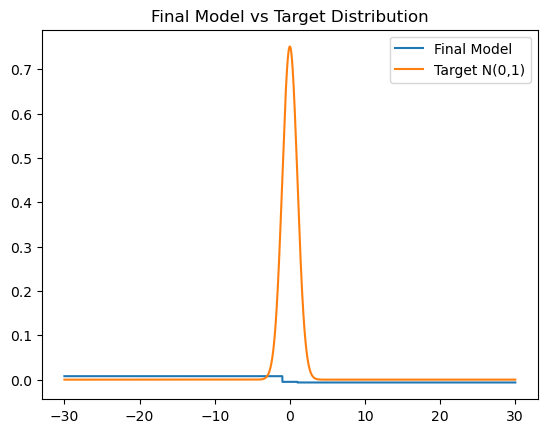

In [110]:
final_model.load_state_dict(callback.best_model_state)
x = torch.linspace(-30, 30, 20000).view(-1, 1).to(device)
psi = final_model(x)
psi = psi / torch.norm(psi)

print(f"final model norm: {torch.norm(psi).item()}")

plt.plot(x.cpu().numpy(), psi.cpu().detach().numpy(), label='Final Model')
plt.plot(x.cpu().numpy(), (1/torch.pi)**(1/4)*torch.exp(-0.5 * x**2).cpu().numpy(), label='Target N(0,1)')
plt.title("Final Model vs Target Distribution")
plt.legend()
plt.show()

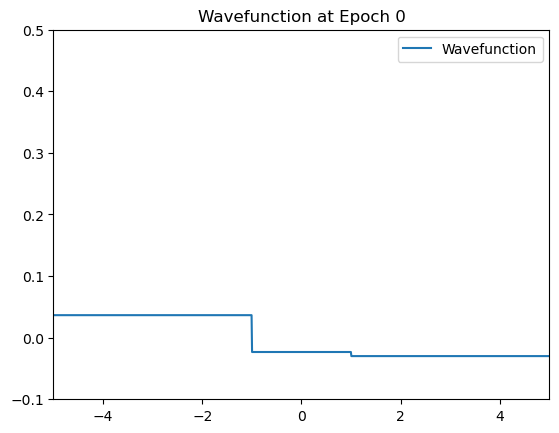

In [111]:
import matplotlib.animation as animation

fig, ax = plt.subplots()
x = torch.linspace(-5, 5, 1000).view(-1, 1).to(device)
def update(frame):
    ax.clear()
    model.load_state_dict(wf_history[frame])
    psi = model(x)
    ax.plot(x.cpu().numpy(), psi.cpu().detach().numpy(), label='Wavefunction')
    ax.set_title(f"Wavefunction at Epoch {frame * 100}")
    ax.legend()
    ax.set_xlim(-5, 5)
    ax.set_ylim(-0.1, 0.5)
    return ax

ani = animation.FuncAnimation(fig, update, frames=len(wf_history), repeat=False)
FFwriter = animation.FFMpegWriter(fps=10)
ani.save("testing.mp4", writer=FFwriter)#, fps=10)

# Check norm is well computed

In [81]:
x = torch.tensor([1.,1.], device=device).view(1, -1)
norm = vector_norm(x)
print(f"Norm of x: {norm.item()}") # should be sqrt(2)
assert torch.isclose(norm, torch.sqrt(torch.tensor(2.0, device=device))), "norm computation error"
# Normalize the vector
x_normalized = x / norm
norm_x_normalized = vector_norm(x_normalized)
assert torch.isclose(norm_x_normalized, torch.tensor(1.0, device=device)), "normalized vector norm should be 1"
print(f"Norm of normalized x: {norm_x_normalized.item()}")

Norm of x: 1.4142135381698608
Norm of normalized x: 0.9999999403953552


# Analytic local energy for the QHO

$$\psi(x) = \frac{1}{\pi^{1/4}}\exp \bigg(-\frac{1}{2}x^2\bigg)$$

$$E_L(x) = \frac{H\psi}{\psi} = -\frac{1}{2\psi}\partial_{x}^2\psi + \frac{1}{2}x^2 = -\frac{1}{2\exp \bigg(-\frac{1}{2}x^2\bigg)}\exp \bigg(-\frac{1}{2}x^2\bigg)(x^2-1)+\frac{1}{2}x^2= -\frac{1}{2}(x^2-1)+\frac{1}{2}x^2 = \frac{1}{2}$$

(0.4, 0.6)

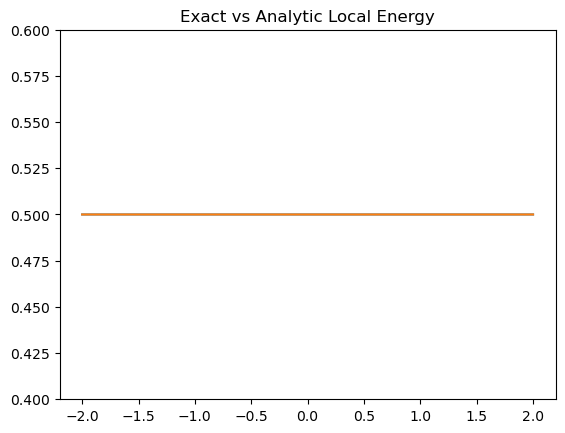

In [73]:
def analytic_EL(x):
    kinetic = -0.5*(x**2-1)
    potential = 0.5*x**2
    return kinetic + potential

class ExactQHO(nn.Module):
    def __init__(self):
        super(ExactQHO, self).__init__()

    def forward(self, x):
        return (1/torch.pi)**(1/4) * torch.exp(-0.5 * x**2)

exact_model = ExactQHO()
exact_model.to(device)
hamiltonian = HarmonicOscillator(model=exact_model)
hamiltonian.to(device)
x_test_EL = torch.linspace(-2, 2, 10000).view(-1, 1).to(device)
x_test_EL.requires_grad = True
exact_EL = hamiltonian(x_test_EL)
plt.plot(x_test_EL.cpu().detach().numpy(), exact_EL.cpu().detach().numpy(), label='Exact EL')
plt.plot(x_test_EL.cpu().detach().numpy(), analytic_EL(x_test_EL).cpu().detach().numpy(), label='Analytic EL')
plt.title("Exact vs Analytic Local Energy")
plt.ylim(0.4, 0.6)